In [ ]:
# hide
import matplotlib.pyplot as plt

# Tutorial: Building the CNN
> Stepping through the creation of the DeepTrackNet model

## Background

[Helgadottir, Argun, and Volpe (2019)](https://www.osapublishing.org/optica/abstract.cfm?uri=optica-6-4-506) described the convolutional neural network architecture that they created and trained for tracking particles in microsocpy images. 

The following diagram, taken from their paper, summarises the architecture of this network.

![Architecture Diagram](./images/DeepTrackArch.png)

In this tutorial I want to step through the layers of the network and understand the inputs and outputs at each stage. The code for defining the network is [elsewhere]()

In summary this network takes an image 51 x 51 pixels as input and passes it through 3 convolutional layers. Effectively these redescribe the images as features. There are then two densly connected layers which finally connect to a 3 value output layers.

   * The first convolutional layer runs 16 3 x 3 kernels over the image, producing 16 channels of size 49 x 49.
   * Each of these channels is like a map of intensity for a different feature, perhaps a top edge for example. During training the network learns the weights for these kernels. In effect it learns what features are important for it to minimise error in the output.
   * In between the red layers are max-pooling layers that downsample the channels.
   * it is typical for the list of features (i.e. number of channels) to rise as we go deeper. This is like detecting richer more complex features as we go along)
   
   
Before implemting this architecture it may be useful to step through the creation of the component parts in PyTorch.

## Loading an image into a Tensor
For working through this example I need to load a sample image. This image needs to be held in a Torch Tensor to have the data in a [Torch Tensor](https://pytorch.org/docs/stable/tensors.html) of the correct dimensions. We must also ensure it is greyscale (single channel intensities) and the correct size (51 x 51) to pass to our proposed network architecture.

PyTorch includes various [transforms](https://pytorch.org/docs/stable/torchvision/transforms.html) that can be used for this task. Here we define three transforms that will be used to transform our image data. 

In [ ]:
import torch
from torchvision import transforms

data_transforms = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize(51),
    transforms.ToTensor()
])

We can use the Python Imaging library (PIL) to load in the image from a file and then apply these transforms. Also we have to make the tensor of the right rank (dimensions) to be fed into our proposed network architecture. 

We create an function that loads an image (with name `image_name`), applies the transforms and returns a tensor holding the image data.

In [ ]:
from PIL import Image

def image_loader(transforms, image_name):
    image = Image.open(image_name)
    image = transforms(image).float()
    #image = image.clone().detach() # was once required
    image = image.unsqueeze(0)
    return image

Now we can use this function to load an example image.

In [ ]:
test_image=image_loader(data_transforms, './images/0000.jpg')
test_image.shape

torch.Size([1, 1, 51, 51])

Reading the shape from right to left, we can see in the shape of this Tensor the 51 x 51 pixels of the input image. The next `1` is the number of channels. Our image is single channel - one number representing intensity per pixel. If we had a colour photograph this would be a `3` representing red, green, and blue intensities. The forth dimension we added using `image.unsqueeze(0)` is required for training the neural network later using *batches* of images. In this example we have only 1 image in our batch. But when training the neural network it is more efficient to feed the network batches of multiple images at once.

## Convolutions

I had to remind myself of how to do a convolution with torch so maybe this section will be useful to you also. 

There are a number of explanatory articles to give an intuituive overview of convolution in images ([for example](https://setosa.io/ev/image-kernels/)). 

Here I focus on the nuts-and-bolts of doing a convolution in torch.

First I define a 3 x 3 kernel, setting the weights by hand. The values of the weight are taken from the [fast.ai example](https://youtu.be/hkBa9pU-H48?t=5371). Convolving this kernel with an image has the effect of 'finding' diagonal edges. 

This is how define the 3 x 3 kernel as a Tensor.

In [ ]:
k = torch.tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,1,3,3)/6
k.shape

torch.Size([1, 1, 3, 3])

Again it might help to understand the dimensionality of the kernel. Reading from right to left the two `3's` represent the size of our kernel. The next `1` represents the number of input channels in the image data. The final `1` represent the number of 3x3 kernels that are applied to the image. So it is essentially the number of output 'channels' that we will get after the convolution operation. At this stage in our example we only want 1 channel output.

PyTorch provides a function that performs a convolution of this kernel with the image, `conv2d`. We can apply it to our test image: 

In [ ]:
import torch.nn.functional as F
edge = F.conv2d(test_image, k)
edge.shape

torch.Size([1, 1, 49, 49])

This gives the output of 49 x 49 because we don't pad the image and the 3x3 kernel can only be applied from pixel (1,1) to (50,50) (rather than (0,0) to (51,51)). We can look at the result comapred to the original image.

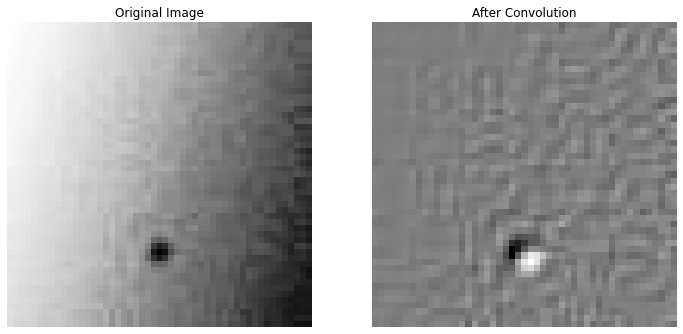

In [ ]:
f,ax=plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(test_image[0,0,:,:],cmap='Greys'); ax[0].set_title('Original Image')
ax[1].imshow(edge[0,0,:,:],cmap='Greys'); ax[1].set_title('After Convolution')
ax[0].axis('off'); _= ax[1].axis('off');

## 16 filters?

The description of the deeptorchtrack neural net includes the following for the first layer:

> The first convolutional layer runs 16 3 x 3 kernels over the image, producing 16 channels of size 49 x 49.

In the previous example we created a kernel of dimensions `[1,1,3,3]` and received an output of shape [1,1,49,49] after applying to the image of shape ([1,1,51,51]). 

But the first convlutional layer of the proposed network creates 16 'channels' of output from one image. Each of these channels is the output of a 3x3 kernel, which could each have different values for the weights. We defined a filter to find diagonal edges. But you could imagine defining kernels to find different features such as horizontal or vertical edges by setting different values in the 3 x 3. So essentially the 16 outputs are the maps of 16 different feature types found in the image.

During training we are going to let the Neural Net learn what weights to put in these kernels and so learn what image features are important in finding the position of a partcile in the image.  

This time use [torch's random functions](https://pytorch.org/docs/stable/torch.html#torch.uniform_) to generate 16 randomly filled (from uniform distribution) 3 x 3 kernels as follows.

In [ ]:
k16 = torch.empty(16,1,3,3).uniform_(-1/6, 1/6)

# show the first 2 kernels
k16[:2], k16.shape

(tensor([[[[-0.0078,  0.0939, -0.0957],
           [-0.0281, -0.0770, -0.1088],
           [-0.0390, -0.0462, -0.0233]]],
 
 
         [[[ 0.0043,  0.0091,  0.0011],
           [-0.0602,  0.0376, -0.0209],
           [ 0.0700,  0.1276,  0.1155]]]]),
 torch.Size([16, 1, 3, 3]))

We can then convolve this multi-channel kernel with our test_image.

We also introduce a RELU function after the convolution because that is specified in the source code from [Helgadottir, Argun, and Volpe (2019)](https://www.osapublishing.org/optica/abstract.cfm?uri=optica-6-4-506). This doesn't change the shape of our output. read about RELUs [here](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning)

In [ ]:
conv1 = F.conv2d(test_image, weight=k16)
conv1 = F.relu(conv1)
conv1.shape

torch.Size([1, 16, 49, 49])

We can examine these 16 channels of output, although I don't expect the results to mean much given the random kernel weights.

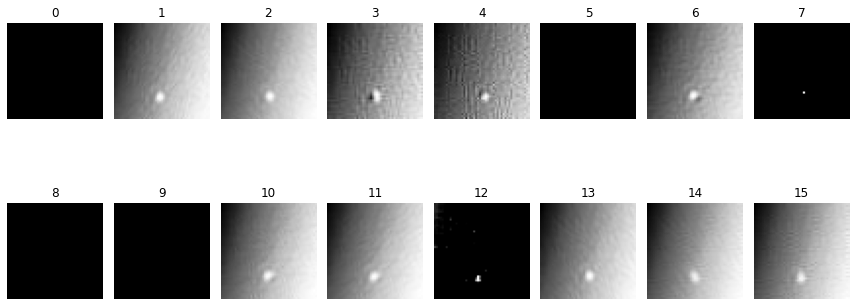

In [ ]:
f,ax=plt.subplots(2,8,figsize=(12,6))
ax=ax.flatten()
for i,a in enumerate(ax):
    a.imshow(conv1[0,i,:,:],cmap='Greys_r'); a.set_title(f'{i}'); a.axis('off');
plt.tight_layout()

## Max pooling layer

> In between the convolutional layers are max-pooling layers that downsample the channels.

This is typical in CNN architectures: downsample the 'image' size (they are now feature maps) but get deeper (more channels). Intuitively this may be thought of as describing the image with progressively larger sets of 'higher-level' features as we move through the network.

Max Pooling is a technique for downsampling. It is similar to convolution in that it slides a filter over the image but instead of computing a weight sum it simply selects the maximum values. So in this case setting a size of 2 means that we go over the image looking for the maximum in each 2 x 2 part of the image.

Torch provides a [max_pool2d](https://pytorch.org/docs/stable/nn.html?highlight=maxpool#torch.nn.MaxPool2d) function that we can simply use on the output of our convolutional layer.

In [ ]:
pool1 = F.max_pool2d(conv1, 2)
pool1.shape

torch.Size([1, 16, 24, 24])

## Repeating for the other convolutional layers

The next group of layers should do this:

> _the second convolutional layer produces 32 feature maps of 22 × 22 px and the second max-pooling layer downsamples them to 11 × 11 px;_

To start, define a kernel that can be convolved with the output of previous layers. This will be a 3 x 3 filter that works on all 16 channels that we produced last time. We want the output to be 32 filters.

In [ ]:
# define kernel
k32 = torch.empty(32,16,3,3).uniform_(-1/6, 1/6)

# do convolution layer
conv2 = F.conv2d(pool1, k32)
conv2 = F.relu(conv2)
print("conv2:",conv2.shape)

# do downsample
pool2 = F.max_pool2d(conv2, 2)
print("pool2:",pool2.shape)

conv2: torch.Size([1, 32, 22, 22])
pool2: torch.Size([1, 32, 11, 11])


Now the final convolutional layer:
    
> _and the third convolutional layer produces 64 feature maps of 9 × 9 px and the third max-pooling layer downsamples them to 4 × 4 px_


In [ ]:
# define kernel
k64 = torch.empty(64,32,3,3).uniform_(-1/6, 1/6)

# do convolution layer
conv3 = F.conv2d(pool2, k64)
conv3 = F.relu(conv3)
print("conv3:",conv3.shape)

# do downsample
pool3 = F.max_pool2d(conv3, 2)
print("pool3:",pool3.shape)

conv3: torch.Size([1, 64, 9, 9])
pool3: torch.Size([1, 64, 4, 4])


In [ ]:
# define kernel
k128 = torch.empty(128,64,3,3).uniform_(-1/6, 1/6)

# do convolution layer
conv4 = F.conv2d(pool3, k128)
conv4 = F.relu(conv4)
print("conv4:",conv4.shape)

# do downsample
pool4 = F.max_pool2d(conv4, 2)
print("pool3:",pool4.shape)

conv4: torch.Size([1, 128, 2, 2])
pool3: torch.Size([1, 128, 1, 1])


## Dense layers

After the 3 convolutional layers with max pooling, the network architecture specifies two densely connected layers. 

A dense layer is a linear operation in which every input is connected to every output by a weight (so there are n_inputs * n_outputs weights). This linear operation is then (normally) followed by a non-linear activation function.

To connect the 2D output of the final convolutional layer to the first dense layer we must first 'flatten' it.

In [ ]:
flattened = torch.flatten(pool4)
print("flat_pool3:",flattened.shape)

flat_pool3: torch.Size([128])


Then we can add two Linear layers. The first takes the 128 inputs from the convolutional layers and gives 32 outputs. The next layer 

In [ ]:
weights1 = torch.randn(32,128)
lin1 = F.linear(flattened, weights1)
lin1 = F.relu(lin1)
print("lin1:",lin1.shape)

weights2 = torch.randn(32,32)
lin2 = F.linear(lin1, weights2)
lin2 = F.relu(lin2)
print("lin2:",lin2.shape)


lin1: torch.Size([32])
lin2: torch.Size([32])


Finally we need to get down to 3 values in the last layer. The position $x$,$y$ and radius $r$. Use a final linear layer to do this transformation:

In [ ]:
weights3 = torch.randn(3,32)
output = F.linear(lin2,weights3)
print("output:",output.shape)

output: torch.Size([3])


In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_GenerateSyntheticImages-Copy1.ipynb.
Converted 00_GenerateSyntheticImages.ipynb.
Converted 01_Models.ipynb.
Converted 02_E1_SingleP_Train.ipynb.
Converted 03_E1_SingleP_Test.ipynb.
Converted 98_Utils.ipynb.
Converted 99_cli.ipynb.
Converted index.ipynb.
Converted tutorial_CNN.ipynb.
